In [3]:
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
import random
import matplotlib.pyplot as plt
import numpy as np

In [9]:
data = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "geometry": {
                "type": "Polygon",
                "coordinates": [[[39.787879, 57.448760], [39.789041, 57.448078], [39.794747, 57.450329], [39.791648, 57.450982], [39.787879, 57.448760]]]
            },
            "properties": {
                "name": "Зона застройки"
            }
        },
        {
            "type": "Feature",
            "geometry": {
                "type": "Polygon",
                "coordinates": [[[39.787589, 57.450669], [39.789544, 57.449244], [39.790215, 57.450619], [39.791792, 57.450538], 
                                 [39.792958, 57.450958], [39.788453, 57.451392], [39.787589, 57.450669]]]
            },
            "properties": {
                "name": "Лесная зона",
                "restriction": "building not allowed"
            }
        },
        {
            "type": "Feature",
            "geometry": {
                "type": "Polygon",
                "coordinates": [[[39.786591, 57.449990], [39.789768, 57.448677], [39.790593, 57.447943], [39.789809, 57.447890],
                                 [39.789427, 57.448355], [39.786284, 57.449609], [39.786591, 57.449990]]]
            },
            "properties": {
                "name": "Водоем",
                "restriction": "building not allowed"
            }
        },
        {
            "type": "Feature",
            "geometry": {
                "type": "LineString",
                "coordinates": [[39.787525, 57.450606], [39.790177, 57.450565], [39.794513, 57.450057]]
            },
            "properties": {
                "name": "Дорога",
                "restriction": "building not allowed"
            }
        }
    ]
}


In [ ]:
def Create_gdf(data):

    '''Функция получает на вход данные и возвращает геодатасет с размеченными областями'''

    geometries = []
    names = []
    restrictions = []

    for feature in data['features']: # Итерируем по фичам
        geom_type = feature['geometry']['type'] # Тип области
        restriction = feature['properties'].get('restriction', None) # Получаем ограничение на область. Если ограничений нет - None

        if geom_type == 'Polygon': # Для полигонов
            coords = feature['geometry']['coordinates'][0] # Получаем координаты
            polygon = Polygon([(lon, lat) for lon, lat in coords]) # Создаем полигон шейпли по координатам
            geometries.append(polygon) # Тут и ниже - собираем строку для gdf
            names.append(feature['properties']['name'])
            restrictions.append(restriction)
        elif geom_type == 'LineString': # Аналогично для линий
            coords = feature['geometry']['coordinates']
            line = LineString([(lon, lat) for lon, lat in coords])
            geometries.append(line)
            names.append(feature['properties']['name'])
            restrictions.append(restriction)
    res = gpd.GeoDataFrame({'geometry' : geometries, 'name' : names, 'restrictions' : restrictions})

    return res

In [14]:
gdf = Create_gdf(data)
gdf

,geometry,name,restrictions
0,"POLYGON ((39.78788 57.44876, 39.78904 57.44808...",Зона застройки,None
1,"POLYGON ((39.78759 57.45067, 39.78954 57.44924...",Лесная зона,building not allowed
2,"POLYGON ((39.78659 57.44999, 39.78977 57.44868...",Водоем,building not allowed
3,"LINESTRING (39.78752 57.45061, 39.79018 57.450...",Дорога,building not allowed


In [37]:
def Plot_empty(gdf:gpd.GeoDataFrame, width:int=20, height:int=40):

    '''Функция получает на вход датасет в формате GeoDataFrame и отрисовывает зоны, зранящиеся в нем.
    Обязательные полня в датасете:
    geometry - зоны в формате geometry
    name - названия зон
    restrictions - ограничения на строительства
    На выходе строит карту полученных зон'''

    fig, ax = plt.subplots(figsize=(width, height))

    # Собираем зоны. Концептуальный пример, для реальной работы и зон и признаков будет больше, как я думаю
    forest_zone = gdf[(gdf['geometry'].type == 'Polygon') & (gdf['restrictions'].notnull()) & (gdf['name'] == 'Лесная зона')]
    water_zone = gdf[(gdf['geometry'].type == 'Polygon') & (gdf['restrictions'].notnull()) & (gdf['name'] == 'Водоем')]
    building_zone = gdf[(gdf['geometry'].type == 'Polygon') & (gdf['restrictions'].isnull())]
    roads = gdf[gdf['geometry'].type == 'LineString']

    # Плотим зомы
    forest_zone.plot(ax=ax, color='red', edgecolor='black', legend=False, alpha=0.5)
    water_zone.plot(ax=ax, color='blue', edgecolor='black', legend=False, alpha=0.5)
    roads.plot(ax=ax, color='black', linewidth=4, legend=False)
    building_zone.plot(ax=ax, color='lightgreen', edgecolor='black', legend=False, alpha=0.5)

    # Задаем легенду
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', label='Лесная зона', markerfacecolor='red', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Водоем', markerfacecolor='blue', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Зоны застройки', markerfacecolor='lightgreen', markersize=10),
        plt.Line2D([0], [0], color='black', linewidth=3, label='Дороги')
    ]

    ax.legend(handles=handles)
    ax.set_title('План зон')
    ax.set_xlabel('Долгота')
    ax.set_ylabel('Широта')
    plt.grid()
    plt.show()

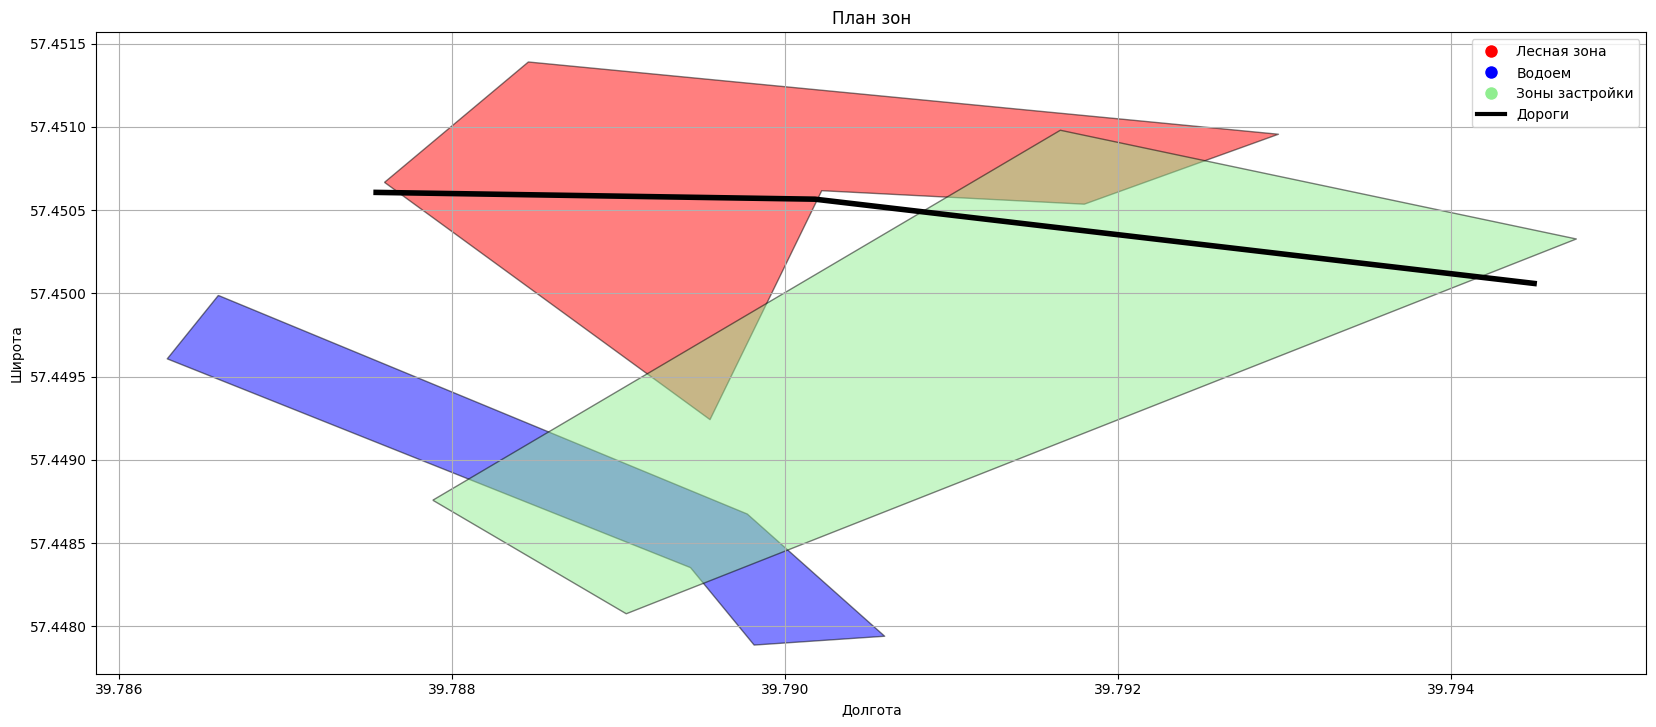

In [38]:
Plot_empty(gdf)